---
title: "[stock prediction] 2.2 주가 데이터 스케일링"
author: "agsu"
date: "7/11/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock4.png
---

# 2. Data Preprocessing  
## 2.2. 주가 데이터 스케일링
이전 글 [2.1 주가 데이터셋 보조지표  추가](https://ag-su.github.io/blog/posts/03.add_index.html)까지 주가 데이터에 보조지표를 추가하여 설명변수를 50개 가량 늘렸다. 그런데 현재 사용하고 있는 통합 종목 주가 데이터는 종목마다 가격이 다르다는 문제점이 존재한다. 이는 성능을 저하시기는 원인이 될 수 있다. 따라서 주가 데이터셋의 전처리 파트에서 스케일링은 매우 중요한 요소라고할 수 있다. `min-max scaling`을 여러 방법으로 시도하고, 전 날 종가로 나누는 `div-close` 방법을 사용하여 총 4가지 스케일링 성능을 비교해보도록 하겠다. 


### 목차 
- (1) 스케일러 비교   
- (2) 스케일러 선택 

### 필요 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import FinanceDataReader as fdr
import pymysql

import warnings
warnings.filterwarnings('ignore')
    
import ta

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)


# 자주쓰는 함수들은 모듈화 함 
import StockFunc as sf 

Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## ✔️ (1) 스케일러 비교 

### 1) min-max scaler (전체 컬럼 + 전체 데이터)
모든 컬럼을 **독립적**으로 종목 별 **전체데이터**에 대해 `min-max scaling` 한다.

In [2]:
def make_dataset_minmax(trading):
    from sklearn.preprocessing import MinMaxScaler
    # 종목코드 불러오기 
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
    
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        sql_query = '''
                    SELECT *
                    FROM stock_{0}
                    WHERE Date BETWEEN '2017-01-01' AND '2021-12-31'
                    '''.format(code)

        
        stock = pd.read_sql(sql = sql_query, con = db_dsml) 
        stock['trading_value'] = stock['Close'] * stock['Volume']
        
        lst_stock = stock.values.tolist()

        
        # 🌟 scaling 
        df_temp = stock.drop(columns=['Date', 'Change', 'Next Change'])
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_temp)
        
        lst_stock_scaled = scaled.tolist()
         
        
        for idx, row in enumerate(lst_stock): 
            date, trading_value = row[0].date().strftime("%Y-%m-%d"), row[-1]
            if trading_value >= trading:
                if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                sub_stock = lst_stock_scaled[idx-9:idx+1] 

                # 10일간의 데이터 
                lst_result = []
                for row2 in sub_stock:
                    lst_result += row2

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return pd.concat([pd.DataFrame(lst_code_date), pd.DataFrame(lst_X), pd.DataFrame(lst_Y)], axis=1)

In [3]:
df_dataset = make_dataset_minmax(trading=1000000000)

100%|██████████████████████████████████████████| 1561/1561 [03:37<00:00,  7.18it/s]


In [4]:
trainX_1, trainY_1, testX_1, testY_1, lst_code_date, lst_code_date_test = sf.split(df_dataset)

print('train dataset: ', trainX_1.shape, trainY_1.shape)
print('test dataset: ', testX_1.shape, testY_1.shape)

train dataset:  (659095, 550) (659095,)
test dataset:  (239818, 550) (239818,)


In [5]:
from xgboost import XGBClassifier
xgb_1 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb_1.fit(trainX_1, trainY_1)

[15:05:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

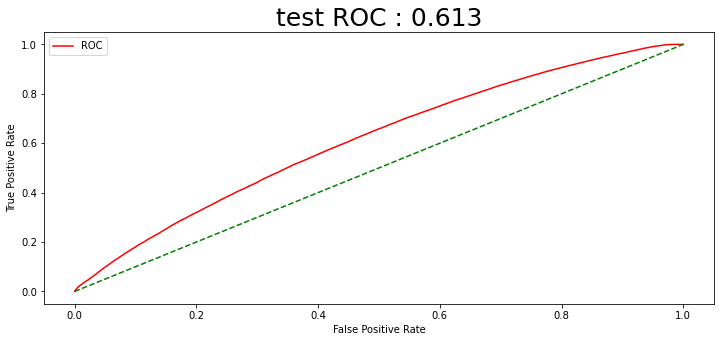

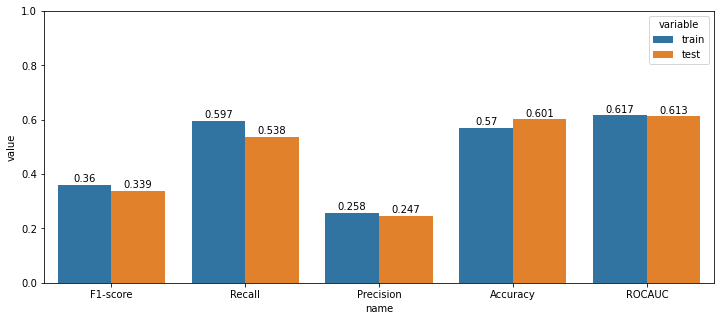

In [6]:
sf.plot_evauate(trainX_1, trainY_1, testX_1, testY_1, xgb_1)

ROCAUC 점수가 지난 0.595의 성능 보다는 향상된 0.613의 성능을 보여주었다.  

<br>
<br>

### 2) min-max scaler (전체 컬럼 +  window size) 
모든 컬럼을 **독립적**으로 종목 별 **10일치**에 대해 `min-max scaling` 한다.

In [47]:
def make_dataset_minmax_window(trading):
    from sklearn.preprocessing import MinMaxScaler
    # 종목코드 불러오기 
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
    
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        sql_query = '''
                    SELECT *
                    FROM stock_{0}
                    WHERE Date BETWEEN '2017-01-01' AND '2021-12-31'
                    '''.format(code)

        
        stock = pd.read_sql(sql = sql_query, con = db_dsml) 
        stock['trading_value'] = stock['Close'] * stock['Volume']
        
        lst_stock = stock.values.tolist()

        
        for idx, row in enumerate(lst_stock): 
            date, trading_value = row[0].date().strftime("%Y-%m-%d"), row[-1]
            if trading_value >= trading:
                if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                arr_sub_stock = np.array(lst_stock[idx-9:idx+1])

                # 🌟 scaling 
                arr_temp = np.concatenate((arr_sub_stock[:, 1:6], arr_sub_stock[:, 8:]), axis=1) 
                scaler = MinMaxScaler()
                scaled = scaler.fit_transform(np.array(arr_temp))

                lst_sub_stock_scaled = scaled.tolist()
                
                # 10일간의 데이터 
                lst_result = []
                for row2 in lst_sub_stock_scaled:
                    lst_result += row2

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return pd.concat([pd.DataFrame(lst_code_date), pd.DataFrame(lst_X), pd.DataFrame(lst_Y)], axis=1)

In [49]:
df_dataset = make_dataset_minmax_window(trading=1000000000)

100%|██████████████████████████████████████████| 1561/1561 [05:53<00:00,  4.41it/s]


In [50]:
trainX_2, trainY_2, testX_2, testY_2, lst_code_date, lst_code_date_test = sf.split(df_dataset)

print('train dataset: ', trainX_2.shape, trainY_2.shape)
print('test dataset: ', testX_2.shape, testY_2.shape)

train dataset:  (659095, 550) (659095,)
test dataset:  (239818, 550) (239818,)


In [51]:
from xgboost import XGBClassifier
xgb_2 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb_2.fit(trainX_2, trainY_2)

[16:05:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

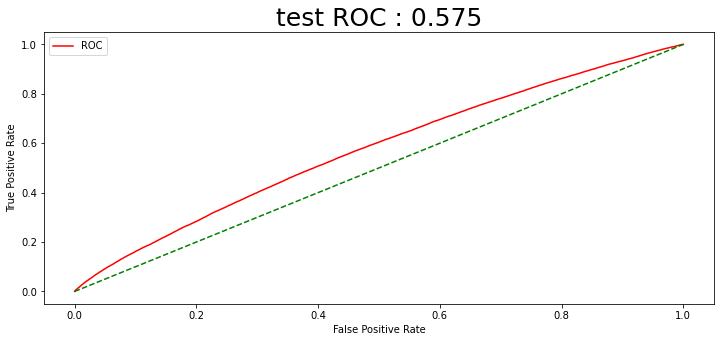

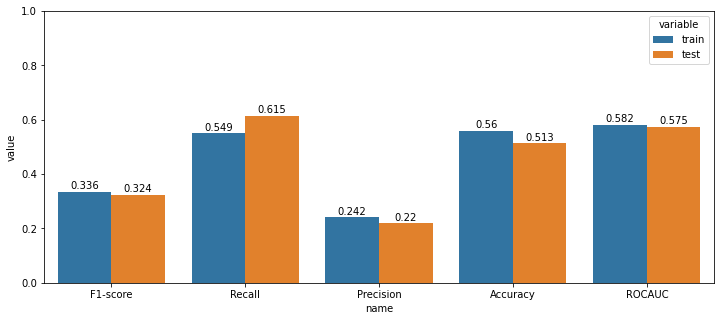

In [52]:
sf.plot_evauate(trainX_2, trainY_2, testX_2, testY_2, xgb_2)

지난 글에서 0.595 였던 ROCAUC 성능이 0.575로 하락한 것을 보였다. 

<br>
<br>

### 3) min-max scaler (가격 관련 컬럼 + 전체 데이터) 
- **가격 관련 컬럼:** 캔들차트의 최솟값, 최댓값으로 min-max scaling
- **나머지 컬럼:** scaling 하지 않는다.

In [53]:
def make_dataset_minmax_price(trading):
    from sklearn.preprocessing import MinMaxScaler
    
    col_price = ['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_etc = ['Volume', 'MFI', 'ADI', 'OBV',
           'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
           'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
           'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
           'WR', 'AO', 'ROC', 'PPO', 'PVO', 'trading_value']
    
    # 종목코드 불러오기 
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
    
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        sql_query = '''
                    SELECT *
                    FROM stock_{0}
                    WHERE Date BETWEEN '2017-01-01' AND '2021-12-31'
                    '''.format(code)

        
        stock = pd.read_sql(sql = sql_query, con = db_dsml) 
        stock['trading_value'] = stock['Close'] * stock['Volume']
        
        lst_stock = stock.values.tolist()

        
        # 🌟 scaling
        # 1) 가격 관련 컬럼 
        df_price = stock[col_price]
        minimum = df_price['Low'].min()
        maximum = df_price['High'].max()
        df_price_scaled = df_price.apply(lambda x: (x-minimum) / (maximum-minimum))
        
        # 2) 나머지 컬럼 
        df_etc = stock[col_etc]
        
        df_scaled = pd.concat([df_price_scaled, df_etc_scaled], axis=1)
        
        lst_stock_scaled = df_scaled.values.tolist()
         
            
        for idx, row in enumerate(lst_stock): 
            date, trading_value = row[0].date().strftime("%Y-%m-%d"), row[-1]
            if trading_value >= trading:
                if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                sub_stock = lst_stock_scaled[idx-9:idx+1] 

                # 10일간의 데이터 
                lst_result = []
                for row2 in sub_stock:
                    lst_result += row2

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return pd.concat([pd.DataFrame(lst_code_date), pd.DataFrame(lst_X), pd.DataFrame(lst_Y)], axis=1)

In [54]:
df_dataset = make_dataset_minmax_price(trading=1000000000)

100%|██████████████████████████████████████████| 1561/1561 [03:53<00:00,  6.68it/s]


In [55]:
trainX_3, trainY_3, testX_3, testY_3, lst_code_date, lst_code_date_test = sf.split(df_dataset)

print('train dataset: ', trainX_3.shape, trainY_3.shape)
print('test dataset: ', testX_3.shape, testY_3.shape)

train dataset:  (659095, 550) (659095,)
test dataset:  (239818, 550) (239818,)


In [56]:
from xgboost import XGBClassifier
xgb_3 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb_3.fit(trainX_3, trainY_3)

[16:15:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

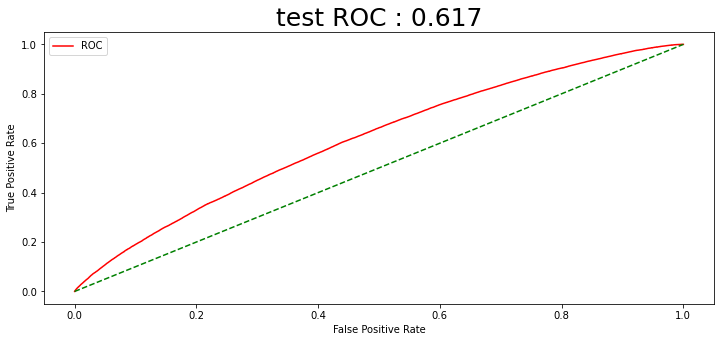

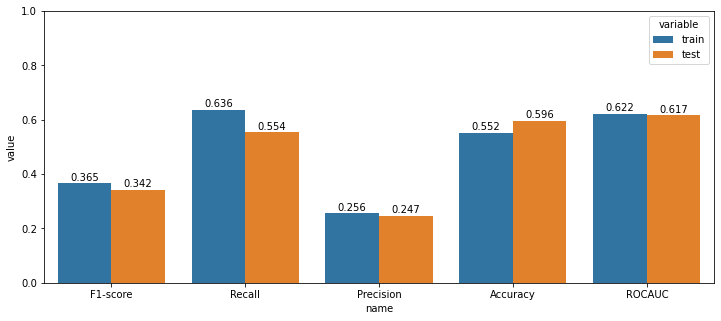

In [57]:
sf.plot_evauate(trainX_3, trainY_3, testX_3, testY_3, xgb_3)

지난 글의 0.595 보다 향상된 성능을 보여주었다. 

<br>
<br>

### 4) div-previous_close (가격 관련 컬럼 + 전체 데이터)
- **가격 관련 컬럼:** 전날 종가로 나누어 스케일링
- **나머지 컬럼:** 스케일링 하지 않는다.

In [58]:
def make_dataset_div_previous_close(trading):
    from sklearn.preprocessing import MinMaxScaler
    
    col_price = ['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
               'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
               'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   

    col_etc = ['Volume', 'MFI', 'ADI', 'OBV',
           'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
           'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
           'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
           'WR', 'AO', 'ROC', 'PPO', 'PVO', 'trading_value']
    
    # 종목코드 불러오기 
    IF = open('../data/code_list.txt')
    lst_code = IF.readlines()

    lst_X = []
    lst_Y = []
    lst_code_date = []
    
    db_dsml = pymysql.connect(
        host = 'localhost', 
        port = 3306, 
        user = '[db username]', 
        passwd = '[db password]', 
        db = '[db name]', 
        charset = 'utf8'
    )
    cursor = db_dsml.cursor()
    
    
    for code in tqdm(lst_code): 
        code = code.strip()
        
        sql_query = '''
                    SELECT *
                    FROM stock_{0}
                    WHERE Date BETWEEN '2017-01-01' AND '2021-12-31'
                    '''.format(code)

        
        stock = pd.read_sql(sql = sql_query, con = db_dsml) 
        stock['PrevClose'] = stock['Close'].shift(1) # 전 날 종가 컬럼 추가
        stock.dropna(inplace=True)
        stock = stock.reset_index(drop=True)
        stock['trading_value'] = stock['Close'] * stock['Volume']
        lst_stock = stock.values.tolist()

        
        # 🌟 scaling
        # 1) 가격 관련 컬럼 
        df_price = stock[col_price]
        df_price_scaled = df_price.apply(lambda x: x / stock['PrevClose'])
        
        # 2) 나머지 컬럼 
        df_etc = stock[col_etc]
        
        df_scaled = pd.concat([df_price_scaled, df_etc], axis=1)
        lst_stock_scaled = df_scaled.values.tolist()

        
        for idx, row in enumerate(lst_stock): 
            date, trading_value = row[0].date().strftime("%Y-%m-%d"), row[-1]
            if trading_value >= trading:
                if (idx < 9) or (idx >= len(lst_stock)-1): # 예외 처리 
                    continue 
                
                # D-9 ~ D0 데이터만 담기 
                sub_stock = lst_stock_scaled[idx-9:idx+1] 

                # 10일간의 데이터 
                lst_result = []
                for row2 in sub_stock:               
                    lst_result += row2

                # D+1 종가 2% 상승 여부 
                label = int(row[7] >= 0.02)
                
                # 종속변수, 독립변수, 종목코드, 날짜 리스트에 추가 
                lst_X.append(lst_result)
                lst_Y.append(label)
                lst_code_date.append([code, date])
            
    return pd.concat([pd.DataFrame(lst_code_date), pd.DataFrame(lst_X), pd.DataFrame(lst_Y)], axis=1)

In [59]:
df_dataset = make_dataset_div_previous_close(trading=1000000000)

100%|██████████████████████████████████████████| 1561/1561 [03:53<00:00,  6.70it/s]


In [60]:
trainX_4, trainY_4, testX_4, testY_4, lst_code_date, lst_code_date_test = sf.split(df_dataset)

print('train dataset: ', trainX_4.shape, trainY_4.shape)
print('test dataset: ', testX_4.shape, testY_4.shape)

train dataset:  (658364, 550) (658364,)
test dataset:  (239817, 550) (239817,)


In [61]:
from xgboost import XGBClassifier
xgb_4 = XGBClassifier(
                   n_jobs=40,
                   scale_pos_weight=4,
                   learning_rate=0.01,
                   max_depth=3,
                   n_estimators=500,
                   ) 

xgb_4.fit(trainX_4, trainY_4)

[16:26:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

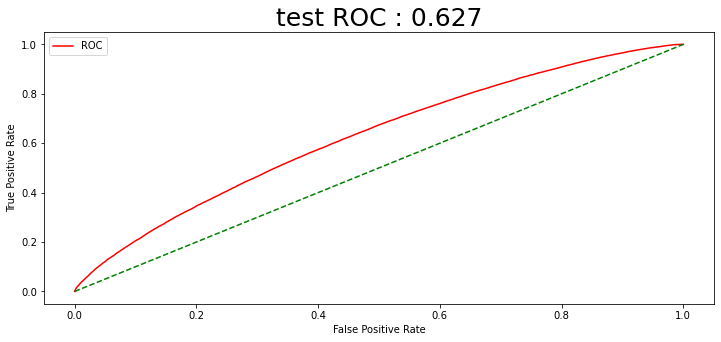

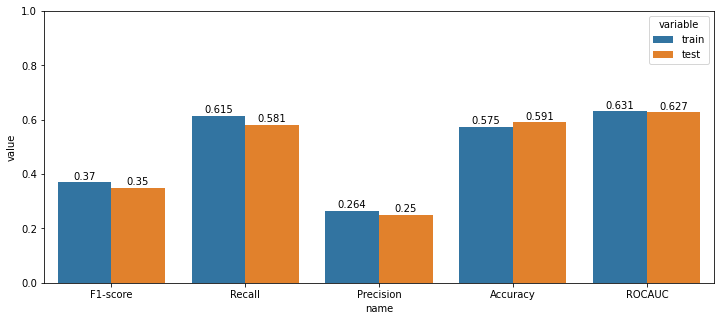

In [62]:
sf.plot_evauate(trainX_4, trainY_4, testX_4, testY_4, xgb_4)

지난 글 0.595 보다 성능 향상이 된 것을 확인하였다.

<br>
<br>

## (2) 스케일러 선택

스케일링을 통해 이전보다 크게 성능 향상이 되었다. 서로 다른 종목 별 가격의 범위를 조정해 주는 작업은 중요하다는 것을 확인하였다. 수익률 시뮬레이션까지 해 본 후, 네 가지 방법 중 지속적으로 사용할 스케일러를 선택하도록 한다. 

### 수익률 비교 

In [67]:
sf.compute_earnings_rate(lst_code_date_test, xgb_1, testX_1, threshold=0.75)

100%|████████████████████████████████████████████| 202/202 [00:04<00:00, 42.12it/s]

Final earning rate : 462.37913 %


In [68]:
sf.compute_earnings_rate(lst_code_date_test, xgb_2, testX_2, threshold=0.75)

0it [00:00, ?it/s]

Final earning rate : 0.0 %


In [69]:
sf.compute_earnings_rate(lst_code_date_test, xgb_3, testX_3, threshold=0.75)

100%|████████████████████████████████████████████| 222/222 [00:05<00:00, 43.23it/s]

Final earning rate : 124.50311 %


In [70]:
sf.compute_earnings_rate(lst_code_date_test, xgb_4, testX_4, threshold=0.75)

100%|████████████████████████████████████████████| 260/260 [00:06<00:00, 42.78it/s]

Final earning rate : 1487.42557 %


<br>

예측확률 임계값을 0.75로 설정하였는데, `4) 전 날 종가로 나누기` 방법의 스케일링이 가장 매매 개수가 많았다. 1년 동안 130번의 매수가 일어났음을 알 수 있다. 그와 동시에 수익률 시뮬레이션에서 수익률이 가장 높게 나온 전 날 종가로 나누는 스케일링 방법을 최종적으로 선택한다.